In [1]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date: 3/20/2022

import sys
import os
import numpy as np
import matplotlib
# matplotlib.use('pdf') # do this because environment does not have GUI backend
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy.special import factorial
import seaborn as sns
import pandas as pd
import re
import statistics
from scipy import stats
import math
import mpl_axes_aligner
# !{sys.executable} -m pip install mygene
import mygene
mg = mygene.MyGeneInfo()
from adjustText import adjust_text

font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)
print('loaded')

# !{sys.executable} -m pip install goenrichment

loaded


### Sequence mismatches per residue EBV type 1 and type 2

In [5]:
import os
import sys
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio import Entrez
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
Entrez.email = 'connorludwig@stanford.edu'


In [6]:
def fetch_gb(gb_id, EBV_type):
    geneList = []
    seqList = []
    handle = Entrez.efetch(db='nuccore', id=gb_id, rettype='gb', retmode='text')
    first = True
    
    for record in SeqIO.parse(handle, 'genbank'):
        for feature in record.features:
            if feature.type == 'CDS':
                if 'gene' not in feature.qualifiers:
                    searchterm = 'product'
                else:
                    searchterm = 'gene'
                gene = feature.qualifiers[searchterm][0]
                seq = feature.qualifiers['translation'][0]
                
                if gene == 'EBNA-3B/EBNA-3C':
                    if first:
                        gene = 'EBNA-3B'
                        first = False
                    else:
                        gene = 'EBNA-3C'
                        
                geneList.append(gene)
                seqList.append(seq)
    
    prot_seq_name = EBV_type + ' Protein Sequence'
    gb_df = pd.DataFrame({'Gene':geneList, prot_seq_name:seqList})
    return gb_df

dfB = fetch_gb('NC_007605.1', 'B95-8')
dfA = fetch_gb('DQ279927.1', 'A876')
df = pd.merge(dfB, dfA, on='Gene', how='outer').dropna().reset_index(drop=True)
df = df.set_index('Gene')

df.to_csv('../Supplemental Tables - CSV/GenBank_EBNA_proteins_B95-8_A876.csv')
df

,B95-8 Protein Sequence,A876 Protein Sequence
Gene,,
LMP-2A,MGSLEMVPMGAGPPSPGGDPDGYDGGNNSQYPSASGSSGNTPTPPN...,MGSLEMVPMGAGPPSPGGDPDGDDGGNNSQYPSASGSSGNTPTPPN...
LMP-2B,MNPVCLPVIVAPYLFWLAAIAASCFTASVSTVVTATGLALSLLLLA...,MNPVCLPVIVAPYLFWLAAIAASCFTASVSTVVTATGLALSLLLLA...
BNRF1,MEERGRETQMPVARYGGPFIMVRLFGQDGEANIQEERLYELLSDPR...,MEDRGRETQMPVARYGGPFIMVRLFGQDGEANIQEQRLYELLSDPR...
BCRF1,MERRLVVTLQCLVLLYLAPECGGTDQCDNFPQMLRDLRDAFSRVKT...,MERRLVVTLQCLVLLYLAPECGGTDQCDNFPQMLRDLRDAFSRVKT...
EBNA-LP,MGDRSEGPGPTRPGPPGIGPEGPLGQLLRRHRSPSPTRGGQEPRRV...,MGDRSEVPGPARPGPPGIGPEGPLGQLLRRHRSPSPTRGGQEPRRV...
...,...,...
BALF1,MRPAKSTDSVFVRTPVEAWVAPSPPDDKVAESSYLMFRAMYAVFTR...,MRPAKSTDSVFVRTPVEAWVAPSPPDDKVAESSYLMFRAMYAVFTR...
BARF1,MARFIAQLLLLASCVAAGQAVTAFLGERVTLTSYWRRVSLGPEIEV...,MARFIAQLLLLASCVAAGQAVTAFLGERVTLTSYWRRVSLGPEIEV...
BNLF2b,MRPGRPLAGFYATLRRSFRRMSKRSKNKAKKERVPVEDRPPTPMPT...,MRPGRPLAGFYATLRRSFRRMSKRSKNKAKKERVPVEDRPPTPMPT...


In [7]:
from Bio import pairwise2
EBNAs = ['EBNA-2', 'EBNA-3A', 'EBNA-3B', 'EBNA-3C']
alignList = []
lenList = []
mismatchList = []

for i in df.T:
    seqB = df.loc[i, 'B95-8 Protein Sequence']
    lenB = len(seqB)
    seqA = df.loc[i, 'A876 Protein Sequence']
    lenA = len(seqA)
    
    if lenA < lenB:
        min_len = lenA
    else:
        min_len = lenB
    
    score = pairwise2.align.globalxx(seqB, seqA, score_only=True)
    alignment = score/min_len
    alignList.append(alignment)
    lenList.append(min_len)
    mismatchList.append(min_len - score)

df2 = df.copy()
df2['Identity'] = alignList
df2['Minimum Length'] = lenList
df2['Mismatches'] = mismatchList
df2 = df2.sort_values(by='Identity', ascending=False).reset_index()
df2 = df2.replace(to_replace=['EBNA-1', 'EBNA-2', 'EBNA-3A', 'EBNA-3B', 'EBNA-3C'], value=['EBNA1', 'EBNA2', 'EBNA3', 'EBNA4', 'EBNA6'])
df2

,Gene,B95-8 Protein Sequence,A876 Protein Sequence,Identity,Minimum Length,Mismatches
0,BLRF2,MSAPRKVRLPSVKAVDMSMEDMAARLARLESENKALKQQVLRGGAC...,MSAPRKVRLPSVKAVDMSMEDMAARLARLESENKALKQQVLRGGAC...,1.000000,162,0.0
1,BKRF4,MAMFLKSRGVRSCRDRRLLSDEEEETSQSSSYTLGSQASQSIQEED...,MAMFLKSRGVRSCRDRRLLSDEEEETSQSSSYTLGSQASQSIQEED...,1.000000,217,0.0
2,BLRF1,MGKVLRKPFAKAVPLLFLAATWLLTGVLPAGASSPTNAAAASLTEA...,MGKVLRKPFAKAVPLLFLAATWLLTGVLPAGASSPTNAAAASLTEA...,1.000000,102,0.0
3,BILF1,MLSTMAPGSTVGTLVANMTSVNATEDACTKSYSAFLSGMTSLLLVL...,MLSTMAPGSTVGTLVANMTSVNATEDACTKSYSAFLSGMTSLLLVL...,1.000000,312,0.0
4,LF2,MAEAYPGGAHAALASRRSSFRNSLRRLRPTEKPDTSFMRGVWKYEI...,MAEAYPGGAHAALASRRSSFRNSLRRLRPTEKPDTSFMRGVWKYEI...,1.000000,429,0.0
...,...,...,...,...,...,...
75,EBNA1,MSDEGPGTGPGNGLGEKGDTSGPEGSGGSGPQRRGGDNHGRGRGRG...,MSDEGPGTGPGNGLGQKEDTSGPDGSSGSGPQRRGGDNHGRGRGRG...,0.932917,641,43.0
76,EBNA3,MDKDRPGPPALDDNMEEEVPSTSVVQEQVSAGDWENVLIELSDSSS...,MDKDRPGLPAPDDNIEEVPSTSGVQERASEGDWENVLIEISDSSSE...,0.863784,925,126.0
77,EBNA6,MESFEGQGDSRQSPDNERGDNVQTTGEHDQDPGPGPPSSGASERLV...,MESFEGEGDSIQSPDNARGDDVQNTGEHIQDPGPGPSTGGASEGLV...,0.826613,992,172.0
78,EBNA4,MKKAWLSRAQQADAGGASGSEDPPDYGDQGNVTQVGSEPISPEIGP...,MKKAWLSRAQQADAGGASGSEDPPDYGDQGNVQQVGSDPISPAIGP...,0.825160,938,164.0


#### Barplot featured in Fig. 4B

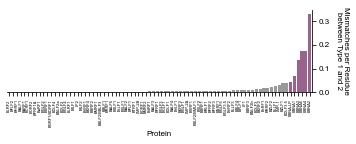

In [8]:
font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

df3 = df2.copy()
df3['Norm Mismatches'] = df3['Mismatches']/df3['Minimum Length']
colors = ['#a35a93']*6 + ['#999999']*(len(df3) - 6)

plt.figure(figsize=(5,2))
sns.barplot(data=df3.sort_values(by='Norm Mismatches', ascending=False), x='Gene', y='Norm Mismatches', palette=colors)
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('Protein')
plt.gca().invert_xaxis()
plt.ylabel('Mismatches per Residue\nbetween Type 1 and 2', rotation=270, labelpad=20)
plt.gca().yaxis.set_label_position('right')
sns.despine(left=True, right=False)
plt.gca().yaxis.tick_right()
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 4/EBV_B95-8_A876_protein_mismatches.png', dpi=1200)

### Generate customized EBNA2 type 1 and type 2 tiling plots

In [14]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date updated: 5/10/2022

# NOTE: these functions use a few global variables, including:
# - hits thresholds for activation and repression screens
# - minimum and maximum screen scores for non-controls to set axis limits
# - dictionary that maps UniProt IDs to protein and virus

# make sure to run the above cells to get these global variables

import mpl_axes_aligner

# this function gets domain start and stop coordinates, as well as max tile score
def domainLimits(temp_df):
    span_starts = []
    span_ends = []
    scores = []
    temp_df_hits = temp_df[temp_df['Hit']==1]
    indices = range(0, len(temp_df_hits))
    temp_df_hits.insert(0, 'index', indices)
    temp_df_hits.set_index('index', inplace=True)
    
    if len(temp_df_hits) == 0:
        return span_starts, span_ends, scores
    temp_start = np.nan
    temp_scores = []
    # create range for all tiles excluding the last tile
    for i in range(0, len(temp_df_hits)):
        # if tile is last one
        if i == (len(temp_df_hits) - 1):
            # if temporary start of domain has been defined
            if ~np.isnan(temp_start):
                span_starts.append(temp_start)
                span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                scores.append(max(temp_scores))
            # if tile is the only tile (first and last)
            elif int(temp_df_hits.loc[i, 'Tile ID'].split('_')[-1]) == 1:
                span_starts.append(temp_df_hits.loc[i, 'Tile Start'])
                span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                scores.append(temp_df_hits.loc[i, 'Avg'])
        # if tile is not last one
        else:
            # if not consecutive
            if (int(temp_df_hits.loc[i, 'Tile ID'].split('_')[-1]) + 1) != (int(temp_df_hits.loc[i+1, 'Tile ID'].split('_')[-1])):
                # if a temporary start of the domain has been defined, then store that start and the end of this tile
                if ~np.isnan(temp_start):
                    span_starts.append(temp_start)
                    span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                    scores.append(max(temp_scores))
                    # reset temporary start to nan
                    temp_start = np.nan
                    temp_scores = []
                # if the tile is at the N-terminus, then store the start/stop of the domain
                elif int(temp_df_hits.loc[i, 'Tile ID'].split('_')[-1]) == 1:
                    span_starts.append(temp_df_hits.loc[i, 'Tile Start'])
                    span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                    scores.append(temp_df_hits.loc[i, 'Avg'])
            # if consecutive
            else:
                # if start of domain is not yet defined
                if np.isnan(temp_start):
                    temp_start = temp_df_hits.loc[i, 'Tile Start']
                    temp_scores.append(temp_df_hits.loc[i, 'Avg'])
                # if tile is in the middle of a domain
                else:
                    temp_scores.append(temp_df_hits.loc[i, 'Avg'])
                    continue
                
    return span_starts, span_ends, scores

###############################
        
# this function makes tiling plots
def plotDomain(gene, temp_df, protDF, domainDict, indivDir_path, save_root):
    # subset for activation
    temp_dfA = temp_df[temp_df['Screen']=='Activation']
    temp_dfA = temp_dfA.drop_duplicates(subset='Tile ID')
    temp_IDsA = list(temp_dfA['Oligo ID'])
    temp_dfA.set_index('Oligo ID', inplace=True)
    
    # get activation points and error
    xA = [(1 + (temp_dfA.loc[ID]['Tile Start'] + temp_dfA.loc[ID]['Tile End'] - 1)/2) for ID in temp_IDsA]
    xerrA = [(temp_dfA.loc[ID]['Tile End'] - temp_dfA.loc[ID]['Tile Start'] + 1)/2 for ID in temp_IDsA]
    yA = [temp_dfA.loc[ID]['Avg'] for ID in temp_IDsA]
    yerrA = list(temp_dfA['Standard Error'])
    
    # get activation domain info
    domain_startsA, domain_endsA, scoresA = domainLimits(temp_dfA)
    print('Activation domain starts/stops/scores:', domain_startsA, domain_endsA, scoresA)

    # subset for repression
    temp_dfR = temp_df[temp_df['Screen']=='Repression']
    temp_dfR = temp_dfR.drop_duplicates(subset='Tile ID')
    temp_IDsR = list(temp_dfR['Oligo ID'])
    temp_dfR.set_index('Oligo ID', inplace=True)
    
    # get repression points and error
    xR = [(1 + (temp_dfR.loc[ID]['Tile Start'] + temp_dfR.loc[ID]['Tile End'] - 1)/2) for ID in temp_IDsR]
    xerrR = [(temp_dfR.loc[ID]['Tile End'] - temp_dfR.loc[ID]['Tile Start'] + 1)/2 for ID in temp_IDsR]
    yR = [temp_dfR.loc[ID]['Avg'] for ID in temp_IDsR]
    yerrR = list(temp_dfR['Standard Error'])
    
    # get repression domain info
    domain_startsR, domain_endsR, scoresR = domainLimits(temp_dfR)
    print('Repression domain starts/stops/scores:', domain_startsR, domain_endsR, scoresR)

    # create axis objects and plot tile centers vs log2(ON:OFF) scores
    fig, ax = plt.subplots(figsize=(2.5,1.2))
    ax2 = ax.twinx()
    colors = ['#23BEDB', '#D7AC00', '#DB3982']
    markersize = 4
    
    # the following stores extended domain and strongest tile info in domainDict
    # it also draws horizontal spans that highlight the strongest tile in each domain
    # activators
    if len(domain_startsA) != 0:
        for s, e, c in zip(domain_startsA, domain_endsA, scoresA):
            domA = temp_dfA[(temp_dfA['Tile Start']>=s) & (temp_dfA['Tile End']<=e)]
            startindex = int(s)
            endindex = int(e)
            domseq = protDF.loc[gene, 'Representative Sequence'][(startindex - 1):endindex]
            max_avg = max(list(domA['Avg']))
            max_coords = [domA[domA['Avg']==max_avg]['Tile Start'][0], domA[domA['Avg']==max_avg]['Tile End'][0]]
            max_seq = domA[domA['Avg']==max_avg]['Tile Sequence'][0]
            
            to_append = [gene, startindex, endindex, len(domseq), domseq,
                         max_coords[0], max_coords[1], max_seq, c, 'Activation']
            for k, v in zip(domainDict.keys(), to_append):
                domainDict[k].append(v)
            
            ax.axvspan(xmin=max_coords[0], xmax=max_coords[1], color='#f5dc79', alpha=0.4, lw=0.8, zorder=-200)
    
    # repressors
    if len(domain_startsR) != 0:
        for s, e, c in zip(domain_startsR, domain_endsR, scoresR):
            domR = temp_dfR[(temp_dfR['Tile Start']>=s) & (temp_dfR['Tile End']<=e)]
            startindex = int(s)
            endindex = int(e)
            domseq = protDF.loc[gene, 'Representative Sequence'][(startindex - 1):endindex]
            max_avg = max(list(domR['Avg']))
            max_coords = [domR[domR['Avg']==max_avg]['Tile Start'][0], domR[domR['Avg']==max_avg]['Tile End'][0]]
            max_seq = domR[domR['Avg']==max_avg]['Tile Sequence'][0]
            
            to_append = [gene, startindex, endindex, len(domseq), domseq,
                         max_coords[0], max_coords[1], max_seq, c, 'Repression']
            for k, v in zip(domainDict.keys(), to_append):
                domainDict[k].append(v)
            
            ax.axvspan(xmin=max_coords[0], xmax=max_coords[1], color='#bbdaee', alpha=0.4, lw=0.8, zorder=-150)
     
    # plot tiles, with activators on y-axis 1 and repressors on y-axis 2
    ax.scatter(xA, yA, c=colors[1], zorder=-100, s=markersize)
    for xi, yi, exi, eyi in zip(xA, yA, xerrA, yerrA):
        ax.errorbar(xi, yi, xerr=exi, yerr=eyi, color=colors[1], zorder=-100, lw=0.8)
    
    ax2.scatter(xR, yR, c=colors[0], zorder=-50, s=markersize)
    for xi, yi, exi, eyi in zip(xR, yR, xerrR, yerrR):
        ax2.errorbar(xi, yi, xerr=exi, yerr=eyi, color=colors[0], zorder=-50, lw=0.8)
    
    EBNAtype = {'P12978':'Type 1', 'Q69022':'Type 2'}
    uID = gene.split('(')[-1]
    ax.set_xlabel('Position along %s EBNA2 (%s)' % (EBNAtype[uID], uID))
    colorsTitle = ['#01a4c2', '#c29d09']
    ax.set_ylabel('Activation\nlog$_2$(ON:OFF)', color=colorsTitle[1], labelpad=1)
    ax2.set_ylabel('Repression\nlog$_2$(OFF:ON)', color=colorsTitle[0], rotation=270, labelpad=17)
    ax2.axhspan(ymin=minScoreA - 0.5, ymax=cutoffR_HHV, color='#FFFFFF', alpha=0.6, zorder=-15)
    ax2.axhline(y=cutoffR_HHV, linestyle='--', color='#666666', lw=1)
    ax.set_ylim(minScoreA - 0.5, maxScoreA + 0.5)
    ax2.set_ylim(minScoreR - 0.5, maxScoreR + 0.5)
    mpl_axes_aligner.align.yaxes(ax, cutoffA_HHV, ax2, cutoffR_HHV, 0.5)

    plt.tight_layout()
    
    # save figure and close current plot
    fig_path = os.path.join(indivDir_path, gene_uID_list_dict2[gene] + save_root)
    # do this because you cannot save files with '|' in the name
    fig_path = fig_path.replace('|', '-')
    fig.savefig(fig_path, dpi=1200)
    plt.close()
    
    return domainDict

###############################

# this function batch produces tiling plots while simultaneously storing domain info
def extractDomains(df, protDF, lib_fullName, indivDir_path, save_root):
    if 'herpesvirus' not in lib_fullName:
        df = df[df['Type']==lib_fullName]
    else:
        df = df[(df['Library'].str.contains('herpesvirus')) & (~df['Type'].str.contains('control'))]
    
    # get hits and edit to avoid regex characters
    tileHits = list(df[df['Hit'] == 1]['Oligo ID'])
    geneHits = []
    for hit in tileHits:
        if '|' in hit:
            geneHits.append('_'.join(hit.split('_')[1:3]))
        else:
            geneHits.append(hit.split('_')[1])

    geneHits = set(geneHits)
    geneHitsLen = str(len(geneHits))
    
    # find domains and construct data frame with domain info
    domainDict = {'Protein ID':[],
                  'Extended Start':[],
                  'Extended End':[],
                  'Extended Length':[],
                  'Extended Sequence':[],
                  'Max Start':[],
                  'Max End':[],
                  'Max Sequence':[],
                  'Max Score':[],
                  'Effect':[]}
    incr = 0
    for gene in geneHits:
        incr += 1
        # make temporary dataframe for each gene
        # '|' character is read as an 'or' by regex, so don't include when searching
        if '|' in gene:
            genesearch = '.'.join(gene.split('|'))
        else:
            genesearch = gene
        temp_df = df[df['Oligo ID'].str.contains(genesearch)]
        temp_df = temp_df.sort_values(by='Oligo ID')
        
        # make a plot with enrichment scores for each gene containing hit tiles
        print('Protein %s of %s: plotting log2(ON:OFF) for %s' % (str(incr), geneHitsLen, gene))
        domainDict = plotDomain(gene, temp_df, protDF, domainDict, indivDir_path, save_root)

    finalDF = pd.DataFrame(domainDict)
    print('Finished')
    
    return finalDF

print('Domain calling/plotting functions defined')

Domain calling/plotting functions defined


In [15]:
# the following creates dictionaries to map UniProt ID to protein and virus names
# this is specifically to produce tiling plot titles and save names
uID_to_gene_df = pd.read_csv('../Supplemental Tables - CSV/uID_protein_virus_mapping_HHV_expanded.csv')
uID_to_gene_df = uID_to_gene_df.rename(columns={'UniProt ID':'Protein ID'})
uID_list = list(uID_to_gene_df['Protein ID'])
uID_to_gene_df['Virus Protein (ProteinID)'] = uID_to_gene_df['Virus'] + ' ' + uID_to_gene_df['Protein'] + ' (' + uID_to_gene_df['Protein ID'] + ')'
uID_to_gene_df['Protein_Virus_ProteinID'] = uID_to_gene_df['Protein'] + '_' + uID_to_gene_df['Virus'] + '_' + uID_to_gene_df['Protein ID']
gene_uID_list1 = list(uID_to_gene_df['Virus Protein (ProteinID)'])
gene_uID_list_dict1 = dict(zip(uID_list, gene_uID_list1))
gene_uID_list2 = list(uID_to_gene_df['Protein_Virus_ProteinID'])
gene_uID_list_dict2 = dict(zip(uID_list, gene_uID_list2))

###############################

df = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ActivD2-ReprD5_detailed.csv')
indivDir_path = '../Individual Figure Panels/Figure 4'
save_root = '_tileScores_EBNA.png'
HHVprot = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_full-length-proteins_uID_sequence.csv')
HHVprot = HHVprot.rename(columns={'Cluster ID':'Entry'})
HHVprot = HHVprot[['Entry', 'Representative Sequence']]
HHVprot = HHVprot.set_index('Entry')

if os.path.isdir(indivDir_path) == False:
    print('Making directory called %s to store plots' % indivDir_path)
    os.mkdir(indivDir_path)

# compute minimum and maximum log2(ON:OFF) for plots
cutoffA_HHV = 1.0846347878236864
cutoffR_HHV = 0.6987727639587654
limsA_HHV = (-9.044003705, 11.45554289)
limsR_HHV = (-3.76771998, 7.7418403210000015)
minScoreA = limsA_HHV[0]
maxScoreA = limsA_HHV[1]
minScoreR = limsR_HHV[0]
maxScoreR = limsR_HHV[1]

EBNAlist = ['P12978', 'Q69022']
df = df[(df['Protein ID'].isin(EBNAlist)) & (~df['Oligo ID'].str.contains('Q3KSV2'))]
HHVprot = HHVprot[HHVprot.index.isin(EBNAlist)] # EBNA2 type 1 and type 2 UniProt IDs

# extract domains and make tiling plots
domDF_HHV = extractDomains(df, HHVprot, 'herpesvirus', indivDir_path, save_root)
domDF_HHV = pd.merge(domDF_HHV, uID_to_gene_df, on='Protein ID', how='left')
domDF_HHV = domDF_HHV.drop_duplicates(subset=['Protein ID', 'Max Score', 'Effect'])


Protein 1 of 2: plotting log2(ON:OFF) for Q69022
Activation domain starts/stops/scores: [351.0] [450.0] [7.313721592]
Repression domain starts/stops/scores: [51.0] [150.0] [1.967592295]
Protein 2 of 2: plotting log2(ON:OFF) for P12978
Activation domain starts/stops/scores: [381.0] [487.0] [8.87737418]
Repression domain starts/stops/scores: [71.0] [180.0] [4.309964462]
Finished


### Comparison of effector domain strengths

#### Dot plot featured in Fig. 4D

In [11]:
# read in domains and keep EBNA proteins only
dom = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_domains.csv')
dom = dom[dom['Protein'].str.contains('EBNA')]

# mapping of UniProt ID to EBV strain
strainDict = {'P03203':'B95-8',
              'P03204':'B95-8',
              'P03211':'B95-8',
              'P12977':'B95-8',
              'P12978':'B95-8',
              'Q1HVF7':'AG876',
              'Q1HVG4':'AG876',
              'Q3KSS4':'GD1',
              'Q3KST0':'GD1',
              'Q3KSV2':'GD1',
              'Q69022':'AG876',
              'Q69138':'AG876',
              'Q69140':'AG876'}

# add strain info and filter out GD1 and non-shared domains
dom['Strain'] = dom['Protein ID'].map(strainDict)
dom = dom[dom['Strain']!='GD1']

# add type information (type 1 vs type 2) and tidy up dataframe
dom['Type'] = dom['Strain'].map({'B95-8':'Type 1', 'AG876':'Type 2'})
dom = dom[['Protein ID', 'Max Start', 'Max End', 'Max Sequence', 'Effect', 'Virus', 'Protein', 'Strain', 'Type']]

# read in screen data to get replicate screen scores for max tile so that final plots have error bars
df = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ActivD2-ReprD5_detailed.csv')
# print(df.columns)
df = df[['Protein ID', 'Tile Start', 'Tile End', 'Tile Sequence', 'Protein', 'Screen', 'Avg', 'Standard Error']] #'R1', 'R2']]
df = df.rename(columns={'Screen':'Effect', 'Tile Start':'Max Start', 'Tile End':'Max End', 'Tile Sequence':'Max Sequence'})
dom = pd.merge(dom, df, how='left', on=['Protein ID', 'Max Start', 'Max End', 'Max Sequence', 'Protein', 'Effect'])

# dom = pd.melt(dom, id_vars=['Protein ID', 'Max Start', 'Max End', 'Max Sequence', 'Effect', 'Virus', 'Protein', 'Strain', 'Type'], var_name='Replicate', value_name='Score')
dom = dom.sort_values(by=['Effect', 'Protein', 'Type']).drop_duplicates()
dom['Unique'] = np.where(dom['Max Start'].isin([791.0, 421.0, 31.0]), 1, 0)
print('Complete')

Complete


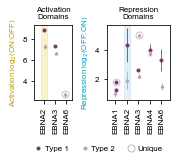

In [22]:
import random
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 2, figsize=(2.5, 2), gridspec_kw={'width_ratios':[3,5]})
Act = dom[dom['Effect']=='Activation']
Rep = dom[dom['Effect']=='Repression']
colorsTitle = ['#01a4c2', '#c29d09']
colorDict = {'Type 1':'#723971', 'Type 2':'#bd9fb7'}

def plot_EBNAs(df, subplot, axlabel, labcolor, title):
    prot_xpos_dict = {}
    xpos_prot_dict = {}
    xpos = 0
    for p, y, t, e, u in zip(list(df['Protein']), list(df['Avg']), list(df['Type']), list(df['Standard Error']), list(df['Unique'])):
        if p not in prot_xpos_dict:
            prot_xpos_dict[p] = xpos
            xpos_prot_dict[xpos] = p
            xpos += 1
        wiggle = random.uniform(-0.1,0.1)
        x = prot_xpos_dict[p] + wiggle
        if t == 'Type 1':
            ax[subplot].plot(x, y, color=colorDict[t], marker='o', markersize=3, zorder=1)
        elif t == 'Type 2':
            ax[subplot].plot(x, y, color=colorDict[t], marker='^', markersize=3, zorder=1)
        ax[subplot].errorbar(x, y, yerr=e, color=colorDict[t], zorder=0, lw=0.8)
        if u == 1:
            ax[subplot].plot(x, y, color='#BBBBBB', marker='o', markersize=7, zorder=-1, mew=0.8, mfc='white')
    
    if subplot == 0:
        ax[subplot].axvspan(-0.25, 0.25, color='#f5dc79', alpha=0.4, zorder=-1)
    else:
        ax[subplot].axvspan(0.75, 1.25, color='#bbdaee', alpha=0.4, zorder=-1)

    ax[subplot].set_xlim(ax[subplot].get_xlim()[0]-0.5, ax[subplot].get_xlim()[1]+0.5)
    ax[subplot].set_xticks(ticks=list(xpos_prot_dict.keys()))
    ax[subplot].set_xticklabels(labels=list(prot_xpos_dict.keys()), rotation=90)
    ax[subplot].legend('', frameon=False)
    ax[subplot].set_ylabel(axlabel, color=labcolor)
    ax[subplot].set_title(title, fontsize=8) 

plot_EBNAs(Act, 0, 'Activation log$_2$(ON:OFF)', colorsTitle[1], 'Activation\nDomains')
plot_EBNAs(Rep, 1, 'Repression log$_2$(OFF:ON)', colorsTitle[0], 'Repression\nDomains')

plt.tight_layout()

legend_elements = [Line2D([0], [0], marker='o', color=colorDict['Type 1'], label='Type 1', mfc=colorDict['Type 1'], markersize=3),
                   Line2D([0], [0], marker='o', color=colorDict['Type 2'], label='Type 2', mfc=colorDict['Type 2'], markersize=3),
                   Line2D([0], [0], marker='o', color='#BBBBBB', label='Unique', mfc='white', markersize=7)]
plt.legend(handles=legend_elements, loc='upper center', frameon=False, bbox_to_anchor=(-0.1, -0.5), labelspacing=0.3, handlelength=0, ncol=3)
   
plt.savefig('../Individual Figure Panels/Figure 4/EBNA_domain_comparison.png', dpi=1200, bbox_inches='tight')

### Venn Diagrams

In [2]:
BBB = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL403-CL048_dox.csv')
AAA = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL404-CL048_dox.csv')
BAB = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL405-CL048_dox.csv')
ABA = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL406-CL048_dox.csv')
filterout = ['EBNA2_B-B-B', 'EBNA2_A-A-A', 'EBNA2_B-A-B', 'EBNA2_A-B-A',
             'mCitrine', 'ORF10', 'VIRF3', 'VIRF4', 'VIRF2', 'IE1', 'RL5A']

def edit_df(df):
    df = df.rename(columns={'Unnamed: 0':'Gene'})
    df = df[~df['Gene'].isin(filterout)]
    dfu = df[(df['log2FoldChange']>1) & (df['padj']<0.05)]
    dfd = df[(df['log2FoldChange']<-1) & (df['padj']<0.05)]
    deu = list(dfu['symbol'])
    ded = list(dfd['symbol'])
    return deu, ded

def compare_list(list1, list2):
    common = [i for i in list1 if i in list2]
    list1_unique = [i for i in list1 if i not in common]
    list2_unique = [i for i in list2 if i not in common]
    num_common = len(common)
    num_list1 = len(list1)
    num_list2 = len(list2)
    return num_common, num_list1, num_list2

def compare3(list1, list2, list3):
    common = [i for i in list1 if (i in list2) & (i in list3)]
    num_common = len(common)
    return num_common

def compare4(list1, list2, list3, list4):
    common = [i for i in list1 if (i in list2) & (i in list3) & (i in list4)]
    num_common = len(common)
    return num_common

BBBu, BBBd = edit_df(BBB)
AAAu, AAAd = edit_df(AAA)
BABu, BABd = edit_df(BAB)
ABAu, ABAd = edit_df(ABA)

namelist = ['BBB', 'AAA', 'BAB', 'ABA']
uplist = [BBBu, AAAu, BABu, ABAu]
downlist = [BBBd, AAAd, BABd, ABAd]
mat = pd.DataFrame(0, index=namelist, columns=namelist)

for j, k in zip(namelist, uplist):
    for l, m in zip(namelist, uplist):
        c, u1, u2 = compare_list(k, m)
        mat.loc[j, l] = c

print(mat)

n123 = compare3(BBBu, AAAu, BABu)
n234 = compare3(AAAu, BABu, ABAu)
n124 = compare3(BBBu, AAAu, ABAu)
n134 = compare3(BBBu, BABu, ABAu)
n1234 = compare4(BBBu, AAAu, BABu, ABAu)

print(n123, n234, n124, n134, n1234)


     BBB  AAA  BAB  ABA
BBB   85   31   15   35
AAA   31   70   17   49
BAB   15   17   31   15
ABA   35   49   15   70
12 14 26 11 11


In [3]:
# The following three scripts are from https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        color map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

def combine_cmaps(cmaplist, numlist):
    cmaplist2 = []
    for c, n in zip(cmaplist, numlist):
        cmaplist2.append(c(np.linspace(0, 1, n)))
    
    cmap = np.vstack((c for c in cmaplist2)) # build stack from bottom to top
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmp', cmap)
    print(cmap)
    return cmap
# colors1 = plt.cm.binary(np.linspace(0., 1, 128))
#     colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 128))

# combine them and build a new colormap
# colors = np.vstack((colors1, colors2))
# mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


<ipython-input-3-ad0e4dde0ead>:49: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  cmap = np.vstack((c for c in cmaplist2)) # build stack from bottom to top
<ipython-input-26-cb5c0b192189>:46: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


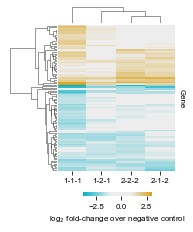

In [26]:
def combine_df(dflist, namelist):
    DF = pd.DataFrame()
    for df, name in zip(dflist, namelist):
        df = df[['symbol', 'log2FoldChange']].rename(columns={'symbol':'Gene', 'log2FoldChange':name})
        df = df[~df['Gene'].isin(filterout)]
        if len(DF) == 0:
            DF = df.copy()
        else:
            DF = pd.merge(DF, df, on='Gene', how='outer')
#     dfu = df[(df['log2FoldChange']>1) & (df['padj']<0.05)]
#     dfd = df[(df['log2FoldChange']<-1) & (df['padj']<0.05)]
#     deu = list(dfu['symbol'])
#     ded = list(dfd['symbol'])
    return DF

x = 1.5
ebna = combine_df([BBB, AAA, BAB, ABA], ['1-1-1', '2-2-2', '1-2-1', '2-1-2'])
ebna = ebna[((ebna['1-1-1']>x) | (ebna['1-1-1']<-x)) | ((ebna['2-2-2']>x) | (ebna['2-2-2']<-x)) | \
            ((ebna['1-2-1']>x) | (ebna['1-2-1']<-x)) | ((ebna['2-1-2']>x) | (ebna['2-1-2']<-x))]
ebna = ebna.set_index('Gene')
# ebna = ebna.fillna(0)
ebna = ebna.dropna()
# mask = ebna.isnull()
ebna = ebna[['1-1-1', '2-2-2', '2-1-2', '1-2-1']]
maxl2fc = max([max(list(ebna[c])) for c in ebna])
minl2fc = min([min(list(ebna[c])) for c in ebna])

num_up = int(round(256*(maxl2fc - 1)/(maxl2fc - minl2fc), 0)) # upregulated genes
num_mid = int(round(256*(2)/(maxl2fc - minl2fc), 0)) # middle
num_down = int(round(256*(-1 - minl2fc)/(maxl2fc - minl2fc), 0)) # downregulated genes

cmap1 = get_continuous_cmap(['#00B0C7', '#EEEEEE'])
cmap2 = get_continuous_cmap(['#EEEEEE', '#EEEEEE'])
cmap3 = get_continuous_cmap(['#EEEEEE', '#DAA520'])
cmap = combine_cmaps([cmap1, cmap2, cmap3], [num_down, num_mid, num_up]) # build stack from bottom to top

# g = sns.clustermap(ebna, mask=ebna.isnull(), cmap=cmap, figsize=(2.5, 2.5), cbar_pos=(0.19,-0.07,0.25,0.02),
#                    dendrogram_ratio=(0.3,0.1), cbar_kws={'orientation': 'horizontal', 'label':'log$_2$FC'})
g = sns.clustermap(ebna, mask=ebna.isnull(), cmap=cmap, figsize=(3.8, 2.7), cbar_pos=(0.31,-0.02,0.25,0.02),
                   dendrogram_ratio=(0.3,0.1), cbar_kws={'orientation': 'horizontal', 'label':'log$_2$ fold-change over negative control'})
ax = g.ax_heatmap
ax.set_yticks([])
ax.set_ylabel(ylabel='Gene', rotation=-90, labelpad=10)
ax.set_xticks(ticks=ax.get_xticks())
# ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
plt.tight_layout()
g.savefig('../Individual Figure Panels/Figure 4/EBNA2_RNA-seq_clustermap.png', dpi=1200) #, bbox_to_inches='tight')


### END

In [2]:
def volcano(df, symbol, product_thresh, savename):
    df['-log10(padj)'] = -np.log10(df['padj'])
    df['-log10(padj)'] = np.where(df['-log10(padj)']==np.inf, 300, df['-log10(padj)'])
    df['Product'] = df['-log10(padj)'] * df['log2FoldChange']
    df.sort_values(by='Product')
    tolabel = pd.concat([df[((df['Product'] < -product_thresh) | (df['Product'] > product_thresh)) & ((df['log2FoldChange'] > 1) | (df['log2FoldChange'] < -1))], df[df['symbol']==symbol]])
    tolabel['-log10(padj)'] = np.where(tolabel['-log10(padj)']>50, 50, tolabel['-log10(padj)'])
    xlabels = list(tolabel['log2FoldChange'])
    ylabels = list(tolabel['-log10(padj)'])
    symbols = list(tolabel['symbol'])
    plt.figure(figsize=(2.5, 2))
    sns.scatterplot(data=df, x='log2FoldChange', y='-log10(padj)', color='#999999', alpha=0.5, linewidth=0, s=5)
    sns.scatterplot(data=tolabel[tolabel['log2FoldChange']>0], x='log2FoldChange', y='-log10(padj)', color='#DAA520', alpha=1, linewidth=0, s=5)
    sns.scatterplot(data=tolabel[tolabel['log2FoldChange']<0], x='log2FoldChange', y='-log10(padj)', color='#00b0c7', alpha=1, linewidth=0, s=5)
    plt.axvline(x=1, ls=':', color='#333333', lw=0.5)
    plt.axvline(x=-1, ls=':', color='#333333', lw=0.5)
    plt.axhline(y=-np.log10(0.05), ls=':', color='#333333', lw=0.5)
    plt.xlim(-5, 5)
    plt.ylim(-5, 55)
    plt.title(symbol + ' vs mCitrine', fontsize=8)
    plt.tight_layout()
    sns.despine()
    texts = []
    for x, y, s in zip(xlabels, ylabels, symbols):
        texts.append(plt.text(x, y, s, fontsize=6))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#333333', lw=0.5))
    
    plt.savefig(savename, dpi=300)
    plt.close()

def GOterms(df, symbol, direction, savename):
    df['Fraction'] = df['Significant']/df['Annotated']
    df['-log10(p)'] = -np.log10(df['result1'])
    plt.figure(figsize=(6,3.5))
    sns.scatterplot(data=df.sort_values(by='Fraction', ascending=False), x='Fraction', y='Term', hue='-log10(p)', size='Significant')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    plt.xlim(0,1)
    plt.xlabel('Fraction of Genes in Set')
    plt.title('%s - GO Terms for %sregulated Genes' % (symbol, direction), fontsize=8)
    plt.tight_layout()
    plt.savefig(savename, dpi=300)
    plt.close()

print('Functions defined')

Functions defined


In [ ]:
# U8deseq = pd.read_csv('Figure_5/20220614_NextSeq_RNA-seq/CL456-CL048_dox.csv')
# U8up = pd.read_csv('Figure_5/20220614_NextSeq_RNA-seq/CL456-CL048_dox_GO_up.csv')
# U8down = pd.read_csv('Figure_5/20220614_NextSeq_RNA-seq/CL456-CL048_dox_GO_down.csv')

# volcano(U8deseq, 'U8', 'Figure_5/20220614_NextSeq_RNA-seq/U8_volcano_replotted_labeled.png')
# GOterms(U8up, 'U8', 'Up', 'Figure_5/20220614_NextSeq_RNA-seq/U8_GO_up_scatter.png')
# GOterms(U8down, 'U8', 'Down', 'Figure_5/20220614_NextSeq_RNA-seq/U8_GO_down_scatter.png')

In [38]:
U8deseq = pd.read_csv('Figure_5/20220713_NextSeq_RNA-seq_U8_VIRFs_mut/CL456-CL048_dox.csv')
U8up = pd.read_csv('Figure_5/20220713_NextSeq_RNA-seq_U8_VIRFs_mut/CL456-CL048_dox_GO_up.csv')
U8down = pd.read_csv('Figure_5/20220713_NextSeq_RNA-seq_U8_VIRFs_mut/CL456-CL048_dox_GO_down.csv')

volcano(U8deseq, 'U8', 50, 'Figure_5/20220713_NextSeq_RNA-seq_U8_VIRFs_mut/U8_volcano_replotted_labeled.png')
GOterms(U8up, 'U8', 'Up', 'Figure_5/20220713_NextSeq_RNA-seq_U8_VIRFs_mut/U8_GO_up_scatter.png')
GOterms(U8down, 'U8', 'Down', 'Figure_5/20220713_NextSeq_RNA-seq_U8_VIRFs_mut/U8_GO_down_scatter.png')

In [15]:
U84deseq = pd.read_csv('Figure_5/20220614_NextSeq_RNA-seq/CL457-CL048_dox.csv')
U84up = pd.read_csv('Figure_5/20220614_NextSeq_RNA-seq/CL457-CL048_dox_GO_up.csv')
U84down = pd.read_csv('Figure_5/20220614_NextSeq_RNA-seq/CL457-CL048_dox_GO_down.csv')

volcano(U84deseq, 'U84', 50, 'Figure_5/20220614_NextSeq_RNA-seq/U84_volcano_replotted_labeled.png')
GOterms(U84up, 'U84', 'Up', 'Figure_5/20220614_NextSeq_RNA-seq/U84_GO_up_scatter.png')
GOterms(U84down, 'U84', 'Down', 'Figure_5/20220614_NextSeq_RNA-seq/U84_GO_down_scatter.png')

In [21]:
E1deseq = pd.read_csv('Figure_5/20220505_NextSeq_RNA-seq/DESeq/CL403-CL048_dox.csv')
volcano(E1deseq, 'EBNA2 Type 1', 25, 'Figure_5/20220505_NextSeq_RNA-seq/EBNA2-1_volcano_replotted_labeled.png')
E2deseq = pd.read_csv('Figure_5/20220505_NextSeq_RNA-seq/DESeq/CL404-CL048_dox.csv')
volcano(E2deseq, 'EBNA2 Type 2', 25, 'Figure_5/20220505_NextSeq_RNA-seq/EBNA2-2_volcano_replotted_labeled.png')

### Volcano plots for manuscript main Fig. 3

In [30]:
def volcano(df, symbol, savename):
    df['-log10(padj)'] = -np.log10(df['padj'])
    df['-log10(padj)'] = np.where(df['-log10(padj)']==np.inf, 300, df['-log10(padj)'])
#     df['Product'] = df['-log10(padj)'] * df['log2FoldChange']
#     df.sort_values(by='Product')
#     tolabel = pd.concat([df[((df['Product'] < -product_thresh) | (df['Product'] > product_thresh)) & ((df['log2FoldChange'] > 1) | (df['log2FoldChange'] < -1))], df[df['symbol']==symbol]])
#     tolabel['-log10(padj)'] = np.where(tolabel['-log10(padj)']>100, 100, tolabel['-log10(padj)'])
    df['-log10(padj)'] = np.where(df['-log10(padj)']>50, 50, df['-log10(padj)'])
    df['Color'] = np.where((df['-log10(padj)']>-np.log10(0.05)) & (df['log2FoldChange']<-1), -1, 0)
    df['Color'] = np.where((df['-log10(padj)']>-np.log10(0.05)) & (df['log2FoldChange']>1), 1, df['Color'])
#     xlabels = list(tolabel['log2FoldChange'])
#     ylabels = list(tolabel['-log10(padj)'])
#     symbols = list(tolabel['symbol'])
    pal = sns.color_palette(['#00b0c7', '#999999', '#DAA520'])
    plt.figure(figsize=(1.8, 2))
    sns.scatterplot(data=df, x='log2FoldChange', y='-log10(padj)', hue='Color', alpha=0.5, linewidth=0, s=5, palette=pal)
    plt.axvline(x=1, ls=':', color='#333333', lw=0.5)
    plt.axvline(x=-1, ls=':', color='#333333', lw=0.5)
    plt.axhline(y=-np.log10(0.05), ls=':', color='#333333', lw=0.5)
    plt.xlim(-10, 10)
    plt.xlabel('log$_2$(Fold Change)')
    plt.ylim(-5, 55)
    plt.xlabel('-log$_{10}$(Adj. p-value)')
    plt.legend('', frameon=False)
    plt.title(symbol + ' vs mCitrine', fontsize=8)
    plt.tight_layout()
    sns.despine()
#     texts = []
#     for x, y, s in zip(xlabels, ylabels, symbols):
#         texts.append(plt.text(x, y, s, fontsize=6))
#     adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#333333', lw=0.5))
    
    plt.savefig(savename, dpi=300)
    plt.close()

def GOterms(df, symbol, direction, savename):
    df['Fraction'] = df['Significant']/df['Annotated']
    df['-log10(p)'] = -np.log10(df['result1'])
    plt.figure(figsize=(6,3.5))
    sns.scatterplot(data=df.sort_values(by='Fraction', ascending=False), x='Fraction', y='Term', hue='-log10(p)', size='Significant')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    plt.xlim(0,1)
    plt.xlabel('Fraction of Genes in Set')
    plt.title('%s - GO Terms for %sregulated Genes' % (symbol, direction), fontsize=8)
    plt.tight_layout()
    plt.savefig(savename, dpi=300)
    plt.close()

print('Functions defined')

Functions defined


In [31]:
U84deseq = pd.read_csv('Figure_5/20220614_NextSeq_RNA-seq/CL457-CL048_dox.csv')
U8deseq = pd.read_csv('Figure_5/20220713_NextSeq_RNA-seq_U8_VIRFs_mut/CL456-CL048_dox.csv')
RL5Adeseq = pd.read_csv('Figure_5/20220505_NextSeq_RNA-seq/DESeq/CL418-CL048_dox.csv')

volcano(U84deseq, 'U84', 'Figure_5/U84_volcano_replotted_unlabeled.png')
volcano(U8deseq, 'U8', 'Figure_5/U8_volcano_replotted_unlabeled.png')
volcano(RL5Adeseq, 'RL5A', 'Figure_5/RL5A_volcano_replotted_unlabeled.png')
